#Radiometer Experiment 4 - Interfering signal mitgation

## Experimental setup

![Lab Setup](https://lh6.googleusercontent.com/-08fQucVu9Sc/VRt4eh2KHEI/AAAAAAAB95I/wEu9fnyYR8A/w813-h688-no/Screenshot_01212015_120231PM.png)

Experiment 4 is used to show additional benefits of using a software defined radio compared to a more traditional radiometer.  One benefit of using a SDR is that key components such as filters are created in software instead of using hardware.  This means that filters can be created on the fly and can be adjusted simply by updating the software.  For this experiment we will use both the Software Defined Radio running GNURadio with the radiometer firmware and a square-law detector that is connected to a data aquisition unit.  The experiment uses a 50 ohm matched load that is attached to the radiometer.  This matched load is then submerged into two different baths, a Liquid Nitrogen at ~ 77 K and an Ice bath at ~ 273.15 K.  Finally the HackRF One is used to generate the offending signal.  This signal is generated within the 1400 to 1425 MHz that the radiometer is configured for.  

## Software Defined Radio setup
The Software Defined Radio uses a N200 SDR with GNURadio running a custom code for the radiometer.  This program includes a GUI that allows for us to monitor the radiometer as well as control many of the properties of the radiometer such as frequency, bandwidth and integration time.  

The program stores the total power data as a binary format which we can then load into a program such as Matlab or Python.  While we can also store the raw I/Q values as well, this results in data files that can be easily 20-40 GB in size for typical 10-15 minute experimental run.  The total power binary files are much smaller (usually less than 200 kB) and make it much easier to use.

The following table shows the configuration of the software defined radio and square-law detector.  This information is important as it let's us know the frequency, bandwidth and integration time.  We can use this information to calculate what the $NE\Delta T$ should be.

|Device  |Frequency  |Bandwidth  |Integration time
|--------|-----------------------
|N200    | 1406 MHz    |10 MHz or Msps| 2 seconds
|$X^2$   | NA    |25 MHz  | NA

The square-law detector does not have a frequency since it does not have a local mixer or demodulator.  It also does not have an integrator as well.  However, as we will soon see we do integrate the square-law data by running it through a low pass filter.  The bandwidth of the square-law detector is controlled by the bandpass filters that we are using on the RF front end.  For the SDR, we can control both frequency and bandwidth and in software we do have an integrator.  While the SDR can go as high as 25 MHz or 25 Msps, the current computer we are using was not able to keep up with that bandwidth.  Overflow errors would begin shortly after the experiment began which means that we are losing information.  Therefore we kept the SDR at 10 MHz.  As we will see soon, this does mean that technically the square-law detector does have a better $NE\Delta T$ compared to the SDR due the fact that it sees the full 25 MHz bandwidth.

<img src="https://lh6.googleusercontent.com/-IjJN8pO95kI/VRt4gQ5Fm-I/AAAAAAAB95c/J6k6-yHcszE/w1118-h667-no/Screenshot_01262015_104749AM.png" alt="SDR" width="100%">

For filtering the signal, we are using an FIR band-reject filter.  Digital filters like an FIR need coefficient values to determine the shape of the filter.  These are often referred to as "taps".  To generate the taps for our filter, we can use a built in tool where we can define our parameters and it will then generate the taps values.  This program has both a GUI and can also simply be called from within our GRC flow-chart as well.  The image below shows an example of the GUI program for our particile type of filter.

A button in our SDR GUI allows us to turn on and off the filter.  This allows us to study the effect of the filter on our TPR measurements.  The image belows shows us what the filter looks like when we turn it on and the interferring signal is also present.

<img src="https://lh4.googleusercontent.com/-tW1hL0r4qEU/VRt4cOrK1HI/AAAAAAAB95A/_qwDOWBpLtE/w952-h688-no/Screenshot01262015_121756AM.png" alt="SDR" width="100%">

The program stores the data as a binary format which we can then load into a program such as Matlab or Python.  

## Square-law detector
The square-law detector is connected to a NI-USB6000 DAQ system.  This records the analog voltage sent from the square-law detector.  A LabView program then receives this data and stores the data in a ASCII CSV file.  This is the same setup used in all of the other experiments.

It also allows us to monitor the data as well.  The square-law detector however does not have any other parameters we can set such as frequency or bandwidth.

## Signal generator
<img src="https://lh6.googleusercontent.com/-1IZk8BgXR2I/VMZyekwq_9I/AAAAAAAB9SQ/lZgBgSai-3s/w859-h644-no/IMG_20150126_105901.jpg" alt="SDR" width="100%">
To generate the offending signals we will use another software defined radio called the HackRF One.  This device is the author's personal SDR that was purchased as part of a Kickstarter campaign.  It has a very wide frequency range from approximatly 100 MHz to 3 GHz.  However the sensitivity and resolution is not as good as the Ettus N200 that is used for our radiometer experiments.  However as a signal generator, it is perfectly fine and serves that purpose very well.
<img src="https://lh4.googleusercontent.com/-QbMV59srkKU/VLBtnx5CHPI/AAAAAAAB86k/IDICHJ8SOKw/w859-h644-no/IMG_20150109_180858.jpg" alt="SDR" width="100%">
For this experiment we are using the LNAs on the radiometer and the interferring signal is injected into the signal chain.  So that we do not overload the LNAs attenuators are placed between the HackRF One and the LNAs.  
- - -

Let's begin our analysis.  We will use Python to load the data files, parse them, analyse the data and graph the data.  All of this will take place within this iPython notebook.  

We begin with setting up our environment and importing required libraries.  Scipy allows us to read in the binary data files that GNURadio uses.  Numpy gives us access to a number of useful tools including graphing.  Finally csv allows us to read in and parse comma seperated files.  The calibration file we use is in a CSV format.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy
import numpy
import scipy.io as sio
import csv

import matplotlib.image as mpimg

import colorline
colorline = colorline.colorline

from scipy.interpolate import interp1d

Use this to set the filename for the data file and CSV Calibration file.

In [3]:
tpr_noflt = 'SDR_TPR_EXP4a.dat'
tpr = 'SDR_TPR_EXP4b.dat'
calib1 = 'calib1.csv'
calib2 = 'calib2.csv'
x2_data_noflt = 'x2data_EXP4a_ASCII.csv'
x2_data = 'x2data_EXP4b_ASCII.csv'

The following reads in the binary file produced by GNURadio.  This stores it into an array that Python can work with.

In [4]:
e = scipy.fromfile(open(tpr_noflt),dtype=scipy.float32)
f = scipy.fromfile(open(tpr),dtype=scipy.float32)

Because of the valve function in GNURadio, there are zeros that get added to the file.  We want to trim out those zeros.

In [5]:
e = numpy.trim_zeros(e)
f = numpy.trim_zeros(f)

Create an index array for plotting.  Also, since we know the interval the data is taken, we can convert this to an actual time.

In [6]:
y = numpy.linspace(0,(len(f)*.5),numpy.size(e))
z = numpy.linspace(0,(len(f)*.5),numpy.size(f))

## Plot the data
We now want to plot the data.  Since we are interested in using these in my thesis, we will also configure matplotlib to use the $\LaTeX$ compiler so the graphs will insert nicely into the thesis.

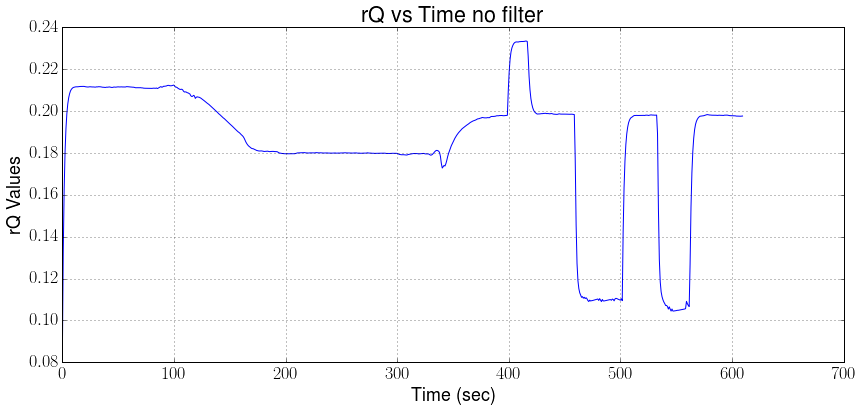

In [7]:
matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})
fig = plt.figure(figsize=(14,6), dpi=300)
plot(y,e)
xlabel('Time (sec)')
ylabel('rQ Values')
title('rQ vs Time no filter')
grid(True)
fig.savefig("sdr_raw_unfiltered.pdf", dpi=300)

## Calibration

The rQ values are the raw values from the total power radiometer and are uncalibrated.  While the graph shows the change in the total power recorded and shows that the radiometer can detect changes in noise temperature, it has no other meaning than that.  What we want is to show what the total power is in relation to a noise temperature.  Since we have recorded the values of the rQ at fixed and known teperatures, we can create a calibration line and calibrate the radiometer.  For this experiment, we found that the following values matched our two known temperatures.  We also had to do this twice.

###First run with no filter on SDR

|rQ Value|X^2 Voltage|Temperature
|--------|-----------------------
|.1800   | 2.1268    |77 K
|.2115   | 2.1948    |271.65 K

###Second run with filter turned on in the SDR

|rQ Value|X^2 Voltage|Temperature
|--------|-----------------------
|.0361   | 2.1234    |77 K
|.0623   | 2.1872    |271.65 K

It should be noted that the square-law values are very similiar.  This is expected since nothing really changes with the square-law detector.  For the SDR you will notice the values go down.  Again, this is expected as we do lose sensitivity with the filter turned on since our effective bandwidth has gone down.  

We can now solve for y = mx + b since we have two equations and two unknowns.

To work with this, a calibration file is created.  This is a very simple CSV file that contains 3 values: The raw rQ value, the raw voltage from the square-law detector (discussed later) and the observed temperature.  The table above would then look like the following in the file.
```
.0361,2.1234,77
.0623,2.1872,271.65
```
- - -
 

We need to read in the values from our CSV file that contains the values

In [8]:
read_csv = open(calib1, 'rb')
csvread = csv.reader(read_csv)
rQ_values = []
temp_values = []
voltage = []

for row in csvread:
    rQ,volt,temp = row
    rQ_values.append(float(rQ))
    voltage.append(float(volt))
    temp_values.append(float(temp))
read_csv.close()

In [9]:
a = numpy.array([[rQ_values[0],1.0],[rQ_values[1],1.0]],numpy.float32)
b = numpy.array([temp_values[0],temp_values[1]])

In [10]:
m = numpy.linalg.solve(a,b)
print m

[ 9732.50203036 -1674.85043508]


Now we apply these values to the array that holds our raw rQ values

In [11]:
g = e*m[0]+m[1]

Now we can re-plot the graph but this time with the calibrated noise temperatures.  We can also colorize this line, however our range will be skewed due to the interferance we have.

In [12]:
m = interp1d([-670,600],[0,1])
a = g[(4*2):]
b = y[(4*2):]

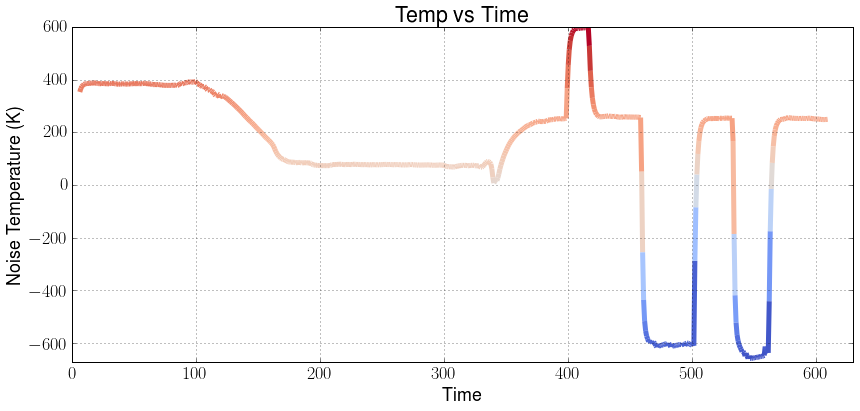

In [13]:
fig = plt.figure(figsize=(14,6), dpi=300)
#plot(y,g)
colorline(b,a,m(a),linewidth=5,cmap='coolwarm')
xlabel('Time')
ylabel('Noise Temperature (K)')
title('Temp vs Time')
grid(True)
axis([0, 630, -670, 600])
fig.savefig("sdr_unfilter_calib.pdf", dpi=300)

- - -
# Square-law data

We now want to look at the data from the Square-Law detector to see what the sqaure-law detector sees, which should be very similiar to the SDR in this case since neither one is filtering out the signal.  In the experiment that was conducted above, a power splitter was used to split the RF signal so that one went to the SDR and the other to a square-law detector (with a 3.1 dB loss though).  Therefore both data should be the same.  Let's read and then plot this data.

In [14]:
read_csv = open(x2_data_noflt, 'rb')
csvread = csv.reader(read_csv)
dummy = []
x2_voltage = []

for row in csvread:
    dummy,x2voltage = row    
    x2_voltage.append(float(x2voltage))
read_csv.close()

Like the SDR data, we want to have a time reference at the bottom.

In [15]:
w = numpy.linspace(0,(len(x2_voltage)*.018),numpy.size(x2_voltage))

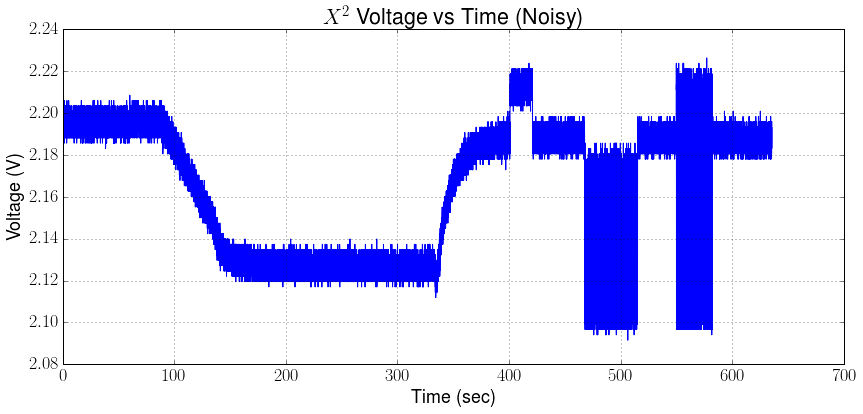

In [16]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(w,x2_voltage)
xlabel('Time (sec)')
ylabel('Voltage (V)')
title('$X^2$ Voltage vs Time (Noisy)')
grid(True)
fig.savefig("x2_noisy.pdf", dpi=300)

The Square-law detector doesn't have a filter on it unlike the data we get from the SDR.  The GNURadio program takes the data and applies a Low Pass Filter to "clean up" the information.  We need to do the same with our Square-law data.

In [17]:
from scipy import signal
N=100
Fc=2000
Fs=1600
h=scipy.signal.firwin(numtaps=N, cutoff=40, nyq=Fs/2)
x2_filt=scipy.signal.lfilter(h,1.0,x2_voltage)

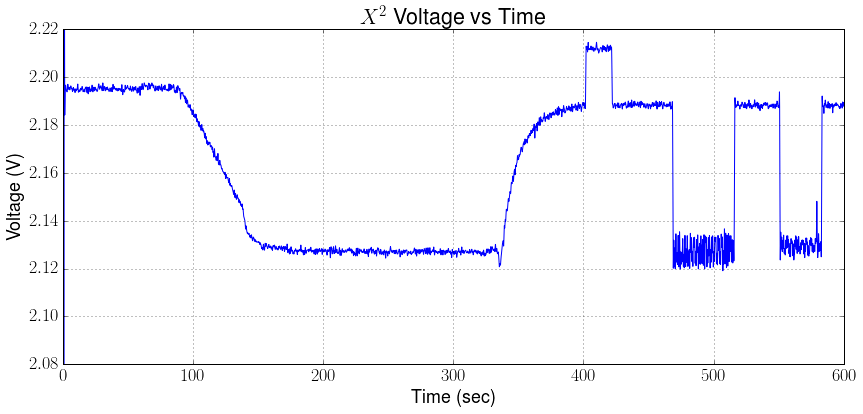

In [18]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(w,x2_filt)
xlabel('Time (sec)')
ylabel('Voltage (V)')
title('$X^2$ Voltage vs Time')
axis([0, 600, 2.08, 2.22])
grid(True)
fig.savefig("x2_voltage.pdf", dpi=300)

Now we wish to calibrate this data as well.  We will use the same file and use the calibration points in that file.

In [19]:
a = numpy.array([[voltage[0],1.0],[voltage[1],1.0]],numpy.float32)
b = numpy.array([temp_values[0],temp_values[1]])

In [20]:
o = numpy.linalg.solve(a,b)
print o

[ 2862.50674446 -6010.97951664]


In [21]:
x2_calib = x2_filt*o[0]+o[1]

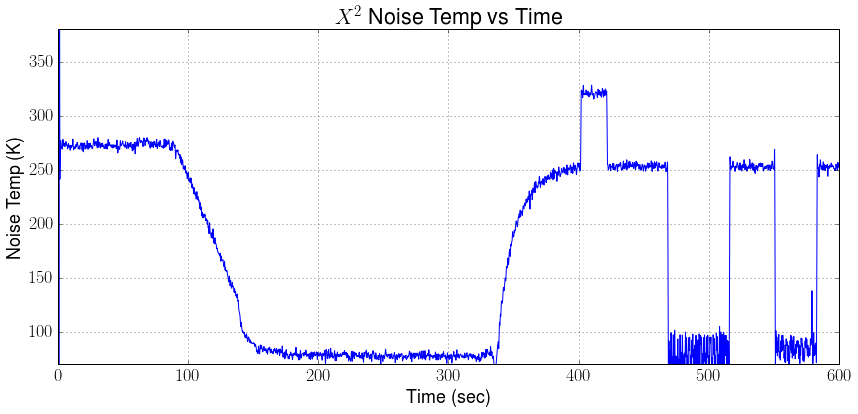

In [22]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(w,x2_calib)
xlabel('Time (sec)')
ylabel('Noise Temp (K)')
title('$X^2$ Noise Temp vs Time')
axis([0, 600, 70, 380])
grid(True)
fig.savefig("x2_calib_interference.pdf", dpi=300)

This looks to be the same as our SDR graph, but let's overlay them to make sure

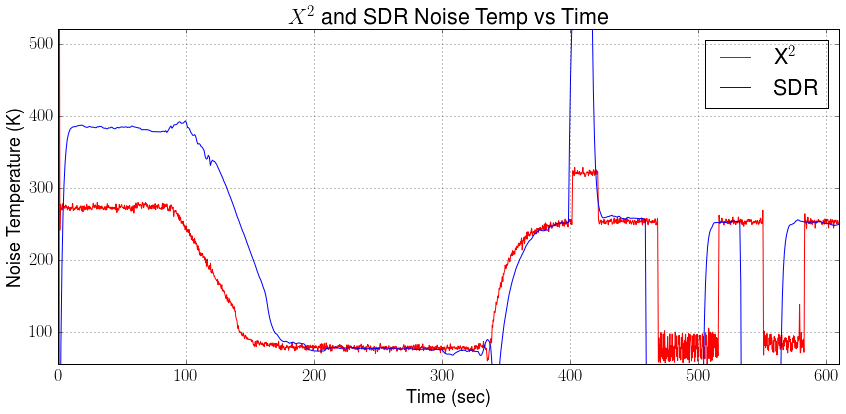

In [23]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(w,x2_calib,'r',label='X^2')
plot(y,g,'b',label='SDR')
xlabel('Time (sec)')
ylabel('Noise Temperature (K)')
title('$X^2$ and SDR Noise Temp vs Time')
axis([0, 610, 40, 620])
grid(True)
legend(loc='upper right')
fig.savefig("calib_unfiltered_both.pdf", dpi=300)

We have some timeshift due to two reasons.  One, the timing isn't always perfect when starting the collection of the two data sets.  And two, we get a timeshift from filtering the square-law data.  Another reason is that there the way the square-law detector and the SDR responses to changes is different.  I have attempted to match them up as best as I can, but some differences are to be expected.

##Filter turned on
We will now look at data collected where the filter is turned on in the SDR.  First let's look at the raw data.

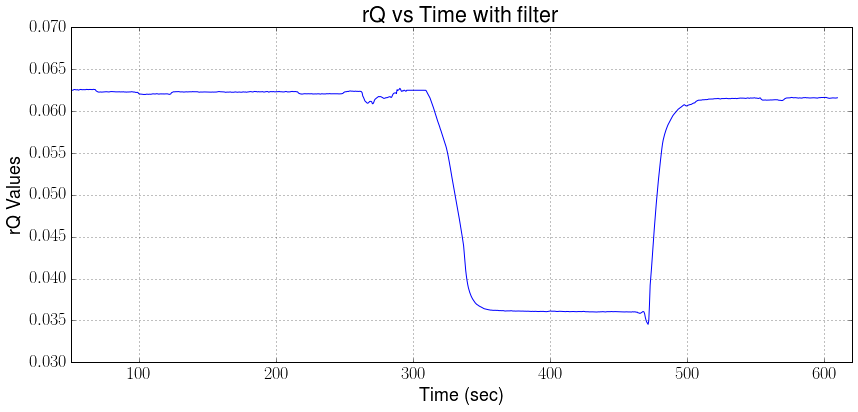

In [24]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(z,f)
xlabel('Time (sec)')
ylabel('rQ Values')
title('rQ vs Time with filter')
axis([50, 620, 0.03, .07])
grid(True)
fig.savefig("raw_filtered.pdf", dpi=300)

We can tell already that the output is much closer to what we normally expect in these types of experiments.  We do not have huge spikes as shown in the earlier graphs.

Once again we want to calibrate this data.

In [25]:
read_csv = open(calib2, 'rb')
csvread = csv.reader(read_csv)
rQ_values = []
temp_values = []
voltage = []

for row in csvread:
    rQ,volt,temp = row
    rQ_values.append(float(rQ))
    voltage.append(float(volt))
    temp_values.append(float(temp))
read_csv.close()

In [26]:
a = numpy.array([[rQ_values[0],1.0],[rQ_values[1],1.0]],numpy.float32)
b = numpy.array([temp_values[0],temp_values[1]])

In [27]:
n = numpy.linalg.solve(a,b)
print n

[ 7156.25039518  -181.34064029]


In [28]:
g = f*n[0]+n[1]

In [29]:
m = interp1d([62,275],[0,1])
c = g[(50*2):]
d = z[(50*2):]

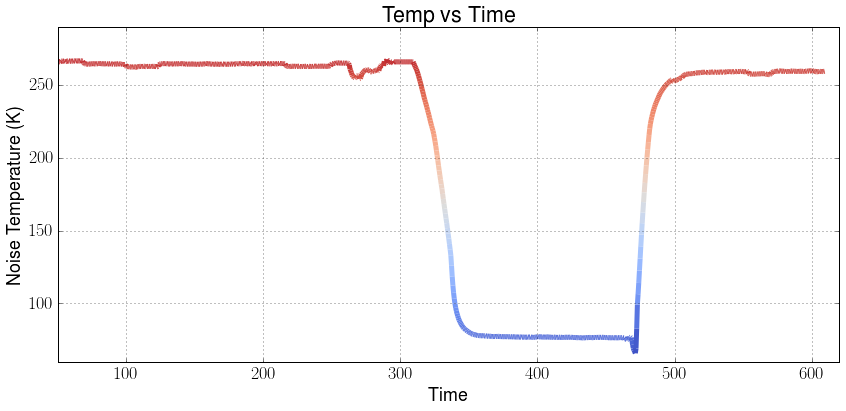

In [30]:
fig = plt.figure(figsize=(14,6), dpi=300)
#plot(z,g)
colorline(d,c,m(c),linewidth=5,cmap='coolwarm')
xlabel('Time')
ylabel('Noise Temperature (K)')
title('Temp vs Time')
axis([50, 620, 60, 290])
grid(True)
fig.savefig("calib_filtered.pdf", dpi=300)

We now want to look at the square-law data.

In [31]:
read_csv = open(x2_data, 'rb')
csvread = csv.reader(read_csv)
dummy = []
x2_voltage = []

for row in csvread:
    dummy,x2voltage = row    
    x2_voltage.append(float(x2voltage))
read_csv.close()

In [32]:
w = numpy.linspace(0,(len(x2_voltage)*.016),numpy.size(x2_voltage))

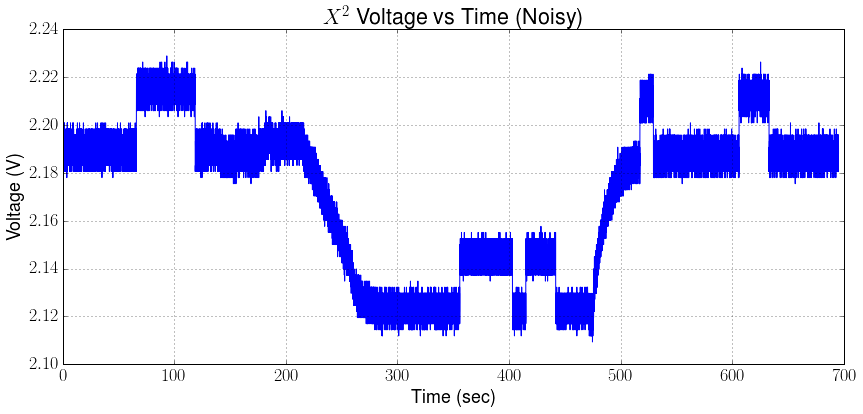

In [33]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(w,x2_voltage)
xlabel('Time (sec)')
ylabel('Voltage (V)')
title('$X^2$ Voltage vs Time (Noisy)')
grid(True)
fig.savefig("raw_x2.pdf", dpi=300)

In [34]:
from scipy import signal
N=100
Fc=2000
Fs=1600
h=scipy.signal.firwin(numtaps=N, cutoff=40, nyq=Fs/2)
x2_filt=scipy.signal.lfilter(h,1.0,x2_voltage)

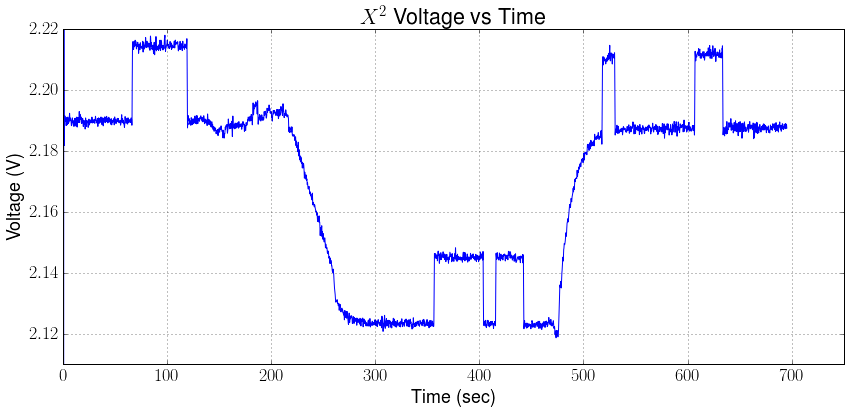

In [35]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(w,x2_filt)
xlabel('Time (sec)')
ylabel('Voltage (V)')
title('$X^2$ Voltage vs Time')
axis([0, 750, 2.11, 2.22])
grid(True)
fig.savefig("raw_x2_smooth.pdf", dpi=300)

In [36]:
a = numpy.array([[voltage[0],1.0],[voltage[1],1.0]],numpy.float32)
b = numpy.array([temp_values[0],temp_values[1]])

In [37]:
o = numpy.linalg.solve(a,b)
print o

[ 3050.93582365 -6401.3570453 ]


In [38]:
x2_calib = x2_filt*o[0]+o[1]

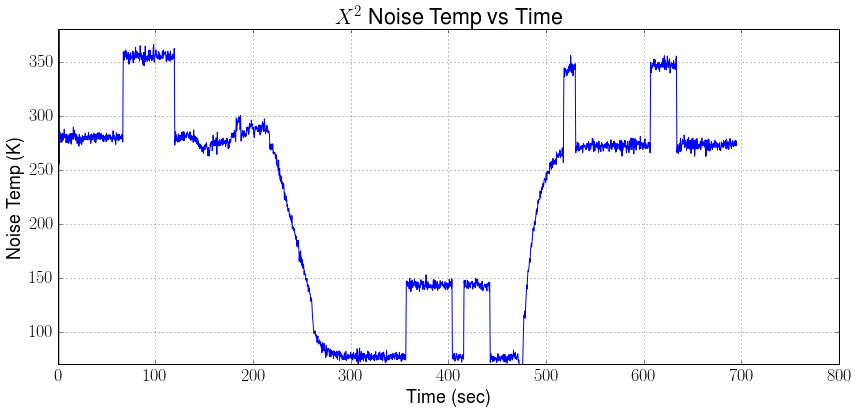

In [39]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(w,x2_calib)
xlabel('Time (sec)')
ylabel('Noise Temp (K)')
title('$X^2$ Noise Temp vs Time')
axis([0, 800, 70, 380])
grid(True)
fig.savefig("calib_x2.pdf", dpi=300)

In [40]:
z = z[(50*2):]
g = g[(50*2):]

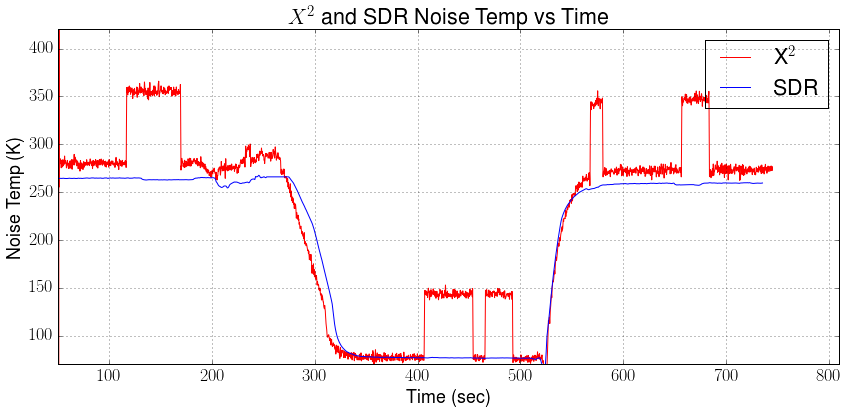

In [41]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(w+50,x2_calib,'r',label='X^2')
plot((z*1.535)-200,g,'b',label='SDR')
xlabel('Time (sec)')
ylabel('Noise Temp (K)')
title('$X^2$ and SDR Noise Temp vs Time')
axis([50, 810, 70, 420])
grid(True)
legend(loc='upper right')
fig.savefig("calib_filtered_both.pdf", dpi=300)

##Analysis
We can see in the graph above that the square law detector detects the pulses from the intefering signal however the SDR with the filter turned on is unaffected.  Therefore the SDR is filtering out the signal and is still able to make readings.

There is a cost with this filtering.  First, adding a filter does add to the computational requirements of the SDR.  Second, we do lose some information with the filter one.  The effective bandwidth is also reduced based on the bandwidth of the filter.  This does change our sensitivity or our $NE\Delta T$.  You will recall that we defined $NE\Delta T$ as the equation below.

(1)  $$NE\Delta T=\frac{T_{A}+T_{sys}}{\sqrt{\beta  \tau}}$$

When the filter is turned on, our bandwidth is now reduced.  This causes for us to have a higher $NE\Delta T$.  We can change our equation for $NE\Delta T$ as seen below.

(2)  $$NE\Delta T=\frac{T_{A}+T_{sys}}{\sqrt{(\beta - \beta_{filter})  \tau}}$$

We can calculate this since we know the bandwidth of the signal we are working with and the bandwidth of the filter.

In [42]:
tau = 2
BSDR = 10e6
BFILTER = 10e3
Tsys = 420

In [43]:
NEAT_SDR = Tsys/sqrt((BSDR)*tau)
NEAT_SDR_FILTER = Tsys/sqrt((BSDR-BFILTER)*tau)

In [44]:
print NEAT_SDR
print NEAT_SDR_FILTER

0.093914855055
0.09396184773
